# [0] Intro

In [1]:
import pandas as pd
import numpy as np
import random, datetime, time
from typing import List, Tuple
import matplotlib.pyplot as plt

In [2]:
data_path = 'data.xlsx'
rates  = pd.read_excel(data_path, sheet_name='Rates')
meters = pd.read_excel(data_path, sheet_name='Meter List')
cons   = pd.read_excel(data_path, sheet_name='Forecasted Consumption')

rates = rates.rename(columns={'Date': 'Date Rate'})
cons = cons.rename(columns={'Date': 'Date Cons'})

In [3]:
# Missing values
rates['Annual Quantity (Max)'] = rates['Annual Quantity (Max)'].fillna(np.inf)

# [1] Transportation Distribution Charge

In [4]:
# Join consumption and meters
r1 = pd.merge(
    right=cons,
    left=meters,
    how='right',
    on='Meter ID'
)

In [5]:
r1

,Meter ID,Exit Zone,Annual Quantity (kWh),Date Cons,kWh
0,1000000603,SC1,12337,2020-10-01,28.782474
1,10588707,EM2,75123,2020-10-01,126.367711
2,10626610,NW1,151779,2020-10-01,326.240595
3,1000000603,SC1,12337,2020-10-02,26.690797
4,10588707,EM2,75123,2020-10-02,118.322449
...,...,...,...,...,...
2185,10588707,EM2,75123,2022-09-29,77.744203
2186,10626610,NW1,151779,2022-09-29,270.357196
2187,1000000603,SC1,12337,2022-09-30,17.927143
2188,10588707,EM2,75123,2022-09-30,73.335098


In [6]:
# Join in the rates
r2 = pd.merge(
    right=r1,
    left=rates,
    on= ['Exit Zone'],
    how='right'
)

# Drop the rates with non-matching AQ
r3 = r2[ ( r2['Annual Quantity (kWh)'] >= r2['Annual Quantity (Min)']  ) & (r2['Annual Quantity (kWh)'] < r2['Annual Quantity (Max)']) ]
#r3.reset_index(drop=True, inplace=True)

In [7]:
# Drop the rates with non-matching date
r3['Delta Dates'] = (r3['Date Cons'] - r3['Date Rate']).dt.days

#max_gap = 183 # an optimalisation (?)
#r3 = r3[ (r3['Delta Dates'] >= 0) & (r3['Delta Dates'] < max_gap)  ]
r3 = r3[ (r3['Delta Dates'] >= 0) ]

/opt/data/playground/projects/bvb-python-env/bvb-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
# Select the rate with smallest positive date delta

# First option: use apply, don't use apply
#r4_slow = r3.groupby(['Meter ID', 'Date Cons' ]).apply(lambda group: group[group['Delta Dates'] == group['Delta Dates'].min()])

# Second option: use an aux vector to filter on
min_dates = r3.groupby(['Meter ID', 'Date Cons' ])['Delta Dates'].transform(min)
r4 = r3[r3['Delta Dates'] == min_dates]

assert len(r4) == cons.shape[0]

In [28]:
# Calculate the day cost
r4['Day Cost (£)'] = r4['Rate (p/kWh)'] *  r4['kWh'] / 100

/opt/data/playground/projects/bvb-python-env/bvb-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
result = r4.groupby('Meter ID').agg({'kWh': 'sum', 'Day Cost (£)': 'sum'}).rename(columns={'kWh': 'Total Estimated Consumption (kWh)',  'Day Cost (£)': 'Total Cost (£)'})
result['Total Estimated Consumption (kWh)'] = round(result['Total Estimated Consumption (kWh)'], 2)
result['Total Cost (£)'] = round(result['Total Cost (£)'], 2)

In [11]:
result

,Total Estimated Consumption (kWh),Total Cost (£)
Meter ID,,
10588707,122450.0,28.50
10626610,303558.0,88.24
1000000603,24674.0,8.27


# [2] List of random meters

In [12]:
rates['Exit Zone'].unique()

array(['EA1', 'EA2', 'EA3', 'EA4', 'EM1', 'EM2', 'EM3', 'EM4', 'LC', 'LO',
       'LS', 'LT', 'LW', 'NE1', 'NE2', 'NE3', 'NO1', 'NO2', 'NT1', 'NT2',
       'NT3', 'NW1', 'NW2', 'SC1', 'SC2', 'SC4', 'SE1', 'SE2', 'SO1',
       'SO2', 'SW1', 'SW2', 'SW3', 'WA1', 'WA2', 'WM1', 'WM2', 'WM3'],
      dtype=object)

In [13]:
zones = ['EA1', 'EA2', 'EA3', 'EA4', 'EM1', 'EM2', 'EM3', 'EM4', 'LC', 'LO',
       'LS', 'LT', 'LW', 'NE1', 'NE2', 'NE3', 'NO1', 'NO2', 'NT1', 'NT2',
       'NT3', 'NW1', 'NW2', 'SC1', 'SC2', 'SC4', 'SE1', 'SE2', 'SO1',
       'SO2', 'SW1', 'SW2', 'SW3', 'WA1', 'WA2', 'WM1', 'WM2', 'WM3']

def random_meters(n:int, zones:List[str], min_aq=10000, max_ax=732001) -> List[Tuple[int, str, int]]:
    return [(i, random.sample(zones, 1)[0], random.randint(min_aq,max_ax) ) for i in range(n)]

In [14]:
random_meters(n=2, zones=zones)

[(0, 'NO1', 309938), (1, 'SW2', 327748)]

# [3] Mock consumption data

In [15]:
def flatten(l):
    return [item for subl in l for item in subl]

In [16]:
def mock_consumption_data(
    meters:List[Tuple[int, str, int]], start_date:datetime.date, end_date:datetime.date, 
    min_consumption=25.0, max_consumpation=500.0) -> pd.DataFrame:
    date_range = pd.date_range(start=start_date, end=end_date)
    df = pd.DataFrame({
        #'Meter ID': sum([ [i] * len(date_range) for (i,_,_) in meters ], []),  # don't use this cute monoid in production :p 
        'Meter ID': flatten([ [i] * len(date_range) for (i,_,_) in meters ]),
        'Date Cons': list(date_range) * len(meters),
        'kWh': np.random.uniform(min_consumption, max_consumpation, size=len(date_range)*len(meters))
    })
    return df

In [17]:
mock_consumption_data(meters=random_meters(n=400, zones=zones), start_date=datetime.date(year=2020, month=10, day=1), end_date=datetime.date(2022, month=9, day=30))

,Meter ID,Date Cons,kWh
0,0,2020-10-01,125.336005
1,0,2020-10-02,322.624791
2,0,2020-10-03,61.538133
3,0,2020-10-04,91.885958
4,0,2020-10-05,107.569015
...,...,...,...
291995,399,2022-09-26,256.759473
291996,399,2022-09-27,187.227496
291997,399,2022-09-28,334.692547
291998,399,2022-09-29,323.052523


# [4] Benchmark of cost function

In [18]:
def transportation_cost_table(meters:pd.DataFrame, rates:pd.DataFrame, cons:pd.DataFrame) -> pd.DataFrame:
    
    # Join consumption and meters
    r1 = pd.merge(
        right=cons,
        left=meters,
        how='right',
        on='Meter ID'
    )
    
    # Join in the rates
    r1 = pd.merge(
        right=r1,
        left=rates,
        on= ['Exit Zone'],
        how='right'
    )

    # Drop the rates with non-matching AQ
    r1 = r1[ ( r1['Annual Quantity (kWh)'] >= r1['Annual Quantity (Min)']  ) & (r1['Annual Quantity (kWh)'] < r1['Annual Quantity (Max)']) ]

    # Drop the rates with non-matching date
    r1['Delta Dates'] = (r1['Date Cons'] - r1['Date Rate']).dt.days
    max_gap = 183 # assumes that the dates of the rates follow a fixed pattern: 1/04 and 1/10 of each year
    r1 = r1[ (r1['Delta Dates'] >= 0) & (r1['Delta Dates'] < max_gap)  ]
    
    # Select the rate with smallest positive date delta
    # First option: use apply, don't use apply:
    #r4_slow = r3.groupby(['Meter ID', 'Date Cons' ]).apply(lambda group: group[group['Delta Dates'] == group['Delta Dates'].min()])
    # Second option: use aux vector to filter on:
    min_dates = r1.groupby(['Meter ID', 'Date Cons' ])['Delta Dates'].transform(min)
    r1 = r1[r1['Delta Dates'] == min_dates]

    assert len(r1) == cons.shape[0]

    # Calculate the day cost
    r1.loc[:, 'Day Cost (£)'] = r1['Rate (p/kWh)'] *  r1['kWh'] / 100
    
    result = r1.groupby('Meter ID').agg({'kWh': 'sum', 'Day Cost (£)': 'sum'}).rename(columns={'kWh': 'Total Estimated Consumption (kWh)',  'Day Cost (£)': 'Total Cost (£)'})
    
    return result

In [19]:
def benchmark(meter_sizes:List[int], end_date=datetime.date(2021, month=9, day=30), years=1):
    elapsed = []

    for size in meter_sizes:
        meters2 = random_meters(n=size, zones=zones)
        cons2 = mock_consumption_data(meters=meters2, start_date=datetime.date(year=2020, month=10, day=1), end_date=end_date)

        start = time.time()
        result = transportation_cost_table(
            meters=pd.DataFrame(meters2, columns=['Meter ID', 'Exit Zone', 'Annual Quantity (kWh)']),
            rates=rates,
            cons=cons2
        )
        end = time.time() - start
        elapsed.append(round(end,2))
        #print("elapsed {:.2f}".format(end))
        print(elapsed)
    
    plt.figure()
    plt.plot(meter_sizes, elapsed)
    plt.title(f'Benmark test with {years} year period'); plt.ylabel('Time (s)'); plt.xlabel('Meter size')

## [4.1] 1 year period

[0.33]
[0.33, 0.58]
[0.33, 0.58, 0.8]
[0.33, 0.58, 0.8, 1.18]
[0.33, 0.58, 0.8, 1.18, 1.53]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53, 5.32]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53, 5.32, 6.15]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53, 5.32, 6.15, 7.17]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53, 5.32, 6.15, 7.17, 7.64]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53, 5.32, 6.15, 7.17, 7.64, 9.13]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53, 5.32, 6.15, 7.17, 7.64, 9.13, 9.86]
[0.33, 0.58, 0.8, 1.18, 1.53, 2.28, 3.05, 4.53, 5.32, 6.15, 7.17, 7.64, 9.13, 9.86, 12.25]


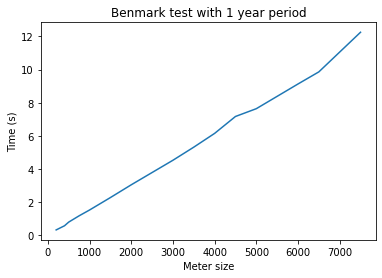

In [20]:
meter_sizes = [200, 400, 500, 750, 1000, 1500, 2000, 3000, 3500, 4000, 4500, 5000, 6000, 6500, 7500]
benchmark(meter_sizes, datetime.date(2021, month=9, day=30), years=1)

## [4.2] 2 year period

[0.21]
[0.21, 0.31]
[0.21, 0.31, 0.58]
[0.21, 0.31, 0.58, 1.25]
[0.21, 0.31, 0.58, 1.25, 1.57]
[0.21, 0.31, 0.58, 1.25, 1.57, 2.33]
[0.21, 0.31, 0.58, 1.25, 1.57, 2.33, 3.05]
[0.21, 0.31, 0.58, 1.25, 1.57, 2.33, 3.05, 4.62]
[0.21, 0.31, 0.58, 1.25, 1.57, 2.33, 3.05, 4.62, 6.15]
[0.21, 0.31, 0.58, 1.25, 1.57, 2.33, 3.05, 4.62, 6.15, 9.29]


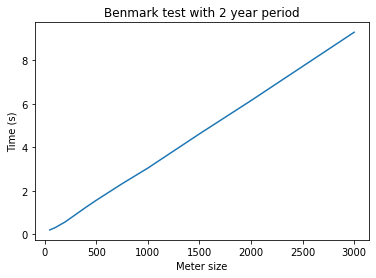

In [21]:
meter_sizes = [50, 100, 200, 400, 500, 750, 1000, 1500, 2000, 3000]
benchmark(meter_sizes, datetime.date(2022, month=9, day=30), years=2)

## [4.3] 3 year period

[0.08]
[0.08, 0.25]
[0.08, 0.25, 0.45]
[0.08, 0.25, 0.45, 1.02]
[0.08, 0.25, 0.45, 1.02, 1.88]
[0.08, 0.25, 0.45, 1.02, 1.88, 2.38]
[0.08, 0.25, 0.45, 1.02, 1.88, 2.38, 3.63]
[0.08, 0.25, 0.45, 1.02, 1.88, 2.38, 3.63, 4.55]
[0.08, 0.25, 0.45, 1.02, 1.88, 2.38, 3.63, 4.55, 6.85]
[0.08, 0.25, 0.45, 1.02, 1.88, 2.38, 3.63, 4.55, 6.85, 12.15]


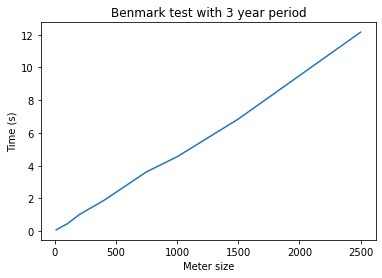

In [22]:
meter_sizes = [10, 50, 100, 200, 400, 500, 750, 1000, 1500, 2500]
benchmark(meter_sizes, datetime.date(2023, month=9, day=30), years=3)

## [4.4] Discussion

Looking at the benchmark plots, I would say that the cost function scales linearly with increasing meter size. We see the same behaviour for increase time periods, 
but the computation time doubles when going from one year to two years: 
- calculating cost for 3000 meters over 1 year takes 4.53 sec
- calculating cost for 3000 meters over 2 year takes 9.29 sec

Of course, honesty compels me to say that the used ranges for the meter sizes are at the limit of what my machine is able to handle. In case of larger sizes, the kernel of my notebook dies due to an OOM error propably. 

# [5] Improvements

One possible improvement would be to parallelize the workload and divide it under clusters in a distributed environment (e.g. Dask or Spark).

Parallelization would be possible in at least two dimensions: both at the client level and time domain.